In [84]:
!pip install update scipy==1.7

You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.


In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from sklearn.metrics import roc_auc_score
from scipy.optimize import minimize
from scipy.special import expit as sigmoid
from pathlib import Path
# import seaborn as sns
from scipy.optimize import minimize, fsolve
import os

In [86]:
import scipy
scipy.__version__

'1.7.0'

In [87]:
class Config:

    #frequently changed 

    model_version = "124th_V2SDCBAM_PL_6ep_2em3lr_32ch_vf+gn+sc01+tm+ts"#
    


    output_dir = "G2Net-Model/"
    kaggle_json_path = 'kaggle/kaggle.json'
    train_folds = [0]


# no need to change below
Config.model_output_folder = Config.output_dir + Config.model_version + "/"
if not os.path.exists(Config.output_dir):
    os.mkdir(Config.output_dir)
if not os.path.exists(Config.model_output_folder):
    os.mkdir(Config.model_output_folder)

    

display(Config.model_output_folder)

'G2Net-Model/121st_V2SD_PL_6ep_2em3lr_32ch_vf+gn+sc01+tm+ts/'

In [88]:
oof_all = pd.read_csv(f'{Config.model_output_folder}/oof_all.csv')

In [89]:
oof_all

,id,target,file_path,fold,preds,tta__vflip,tta__add_gaussian_noise,tta__timemask,tta__shuffle01,tta__time_shift,avg
0,00001f4945,0,./output/whiten-train-w0/00001f4945.npy,0,0.099930,0.089354,0.097569,0.118715,0.082655,0.089527,0.091259
1,00007a006a,0,./output/whiten-train-w0/00007a006a.npy,0,0.109531,0.100988,0.111113,0.116100,0.129147,0.102913,0.110756
2,0000bb9f3e,1,./output/whiten-train-w0/0000bb9f3e.npy,0,0.999744,0.999815,0.999741,0.999732,0.999753,0.999703,0.999782
3,0000c3b9c9,0,./output/whiten-train-w0/0000c3b9c9.npy,0,0.161823,0.157209,0.166805,0.160586,0.191369,0.116280,0.167433
4,00014b7a9d,1,./output/whiten-train-w0/00014b7a9d.npy,0,0.131049,0.099187,0.131330,0.145078,0.140381,0.122459,0.117907
...,...,...,...,...,...,...,...,...,...,...,...
559995,fffe39b914,1,./output/whiten-train-w0/fffe39b914.npy,4,0.999987,0.999988,0.999987,0.999988,0.999988,0.999986,0.999987
559996,fffe76e415,1,./output/whiten-train-w0/fffe76e415.npy,4,0.217293,0.196383,0.218607,0.218664,0.172150,0.246506,0.195296
559997,fffe81f2ec,0,./output/whiten-train-w0/fffe81f2ec.npy,4,0.071158,0.076111,0.071729,0.070844,0.050760,0.062879,0.068675
559998,ffff1a0fee,1,./output/whiten-train-w0/ffff1a0fee.npy,4,0.983958,0.974472,0.983982,0.987609,0.986911,0.988522,0.980039


target
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: preds, dtype: object

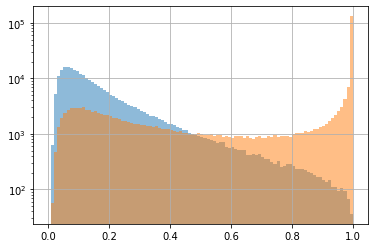

In [90]:
oof_all.groupby("target")["preds"].hist(bins=100, alpha=0.5, range=[0, 1],log=True)

In [91]:
# plt.figure(figsize=(8,6))
# plt.hist(oof, bins=100, alpha=0.5, range=[0, 1])
# plt.suptitle(f"Unit: {pre_method}")
# plt.legend(loc='upper right');

In [92]:
!free -g

              total        used        free      shared  buff/cache   available
Mem:            251          50          12           1         188         197
Swap:             1           1           0


In [93]:
oof_df = oof_all

In [94]:
def score_oof(oof, full=False, col=None, get_list=False):
    if col is None:
        col = "prediction"
    if full:
        return round(roc_auc_score(oof["target"], oof[col]),6)
    else:
        scores = [roc_auc_score(df["target"], df[col]) for _, df in oof.groupby("fold")]
        if get_list:
            return scores
        return round(np.mean(scores),6)
    
def score_oof_fast(oof, full=False, col=None, get_list=False):
    if col is None:
        col = "prediction"
    if full:
        return round(fast_auc(oof["target"], oof[col]),6)
    else:
        scores = [fast_auc(df["target"], df[col]) for _, df in oof.groupby("fold")]
        if get_list:
            return scores
        return round(np.mean(scores),6)

from numba import jit

@jit
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

Index(['preds', 'tta__vflip', 'tta__add_gaussian_noise', 'tta__timemask',
       'tta__shuffle01', 'tta__time_shift'],
      dtype='object') (560000, 11)


/tmp/ipykernel_381/3537683612.py:25: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fast_auc" failed type inference due to: non-precise type pyobject
During: typing of argument at /tmp/ipykernel_381/3537683612.py (27)

File "../tmp/ipykernel_381/3537683612.py", line 27:
<source missing, REPL/exec in use?>

  @jit
/tmp/ipykernel_381/3537683612.py:25: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "fast_auc" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "../tmp/ipykernel_381/3537683612.py", line 32:
<source missing, REPL/exec in use?>

  @jit
/opt/conda/lib/python3.8/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "fast_auc" was compiled in object mode without forceobj=True, but has lifted loops.

File "../tmp/ipykernel_381/3537683612.py", line 27:
<source missing, REPL/exec in use?>

  war

Inital Blend OOF: 0.880928
Optimised Blend OOF: 0.881107
----------------------------------------------------------------------
preds                                    Optimised Weights: 7.797196678443609e-05
tta__vflip                               Optimised Weights: 0.6033792167851374
tta__add_gaussian_noise                  Optimised Weights: 0.16364701185297326
tta__timemask                            Optimised Weights: 0.0950746165241953
tta__shuffle01                           Optimised Weights: 0.28977677405259084
tta__time_shift                          Optimised Weights: 0.00025781355844289427
CPU times: user 31.6 s, sys: 1.15 s, total: 32.7 s
Wall time: 32.8 s


<AxesSubplot:>

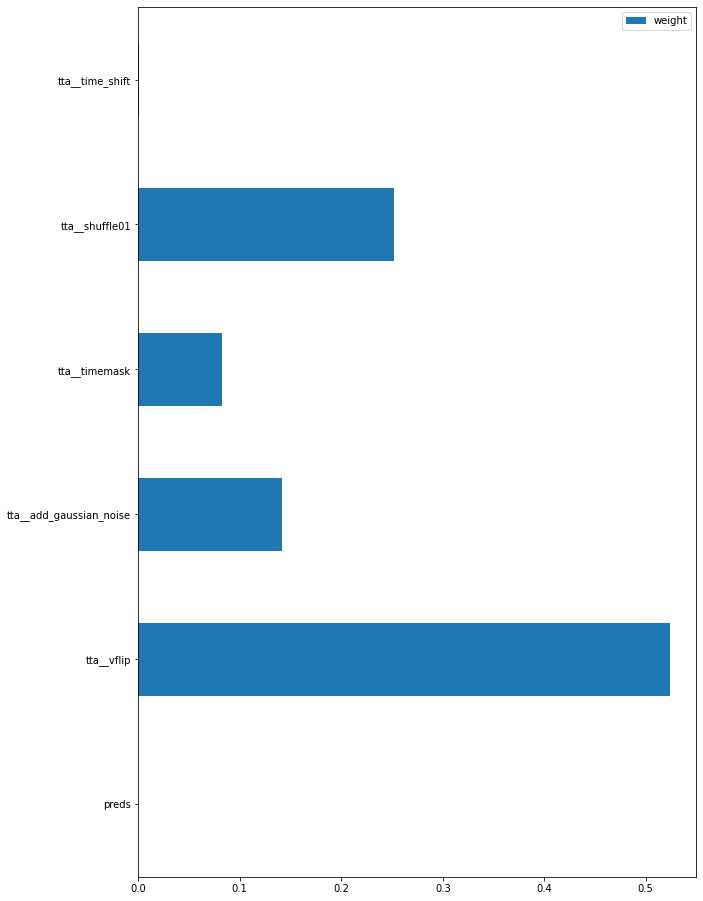

In [95]:
%%time
sci_opt_preds = oof_df.copy() 
model_cols = oof_df.columns[4:-1]
X = sci_opt_preds[model_cols].values
print(model_cols, sci_opt_preds.shape)
def get_score(weights, oof=sci_opt_preds):
    weights = np.array(weights)
    sci_opt_preds["prediction"] = (weights * X).sum(axis=1)
    return -score_oof_fast(sci_opt_preds)

tol = 1e-10
init_guess = [1 / len(model_cols)] * len(model_cols)
bnds = [(0, 1) for _ in range(len(model_cols))]
print('Inital Blend OOF: {:.6f}'.format(-get_score(init_guess)))
res_scipy = minimize(fun = get_score, 
                    x0 = init_guess, 
                    method = 'Nelder-Mead', 
                    bounds = bnds, 
                    tol = tol)
print('Optimised Blend OOF: {:.6f}'.format(-res_scipy.fun))
sci_cv_score = -res_scipy.fun
print('-' * 70)
for n, key in enumerate(model_cols):
    print(f'{key:40s} Optimised Weights:', res_scipy.x[n])
ws = res_scipy.x 
ws = ws / np.sum(ws) # The nelder-mead method requires normalization because the sum of the weights does not equal 1.
pd.DataFrame(dict(zip(model_cols,ws)),index=["weight"]).T.plot(kind="barh",figsize=(10,16))

In [96]:
np.sum(ws) 

1.0000000000000004

In [97]:
for n, key in enumerate(model_cols):
    print(f'{key:40s} Optimised Weights:', ws[n])

preds                                    Optimised Weights: 6.767146299779623e-05
tta__vflip                               Optimised Weights: 0.5236696729120477
tta__add_gaussian_noise                  Optimised Weights: 0.14202838743217283
tta__timemask                            Optimised Weights: 0.082514763439711
tta__shuffle01                           Optimised Weights: 0.2514957497113554
tta__time_shift                          Optimised Weights: 0.0002237550417155951


In [98]:
oof_weight = {key:ws[n] for n, key in enumerate(model_cols) }

In [99]:
oof_weight

{'preds': 6.767146299779623e-05,
 'tta__vflip': 0.5236696729120477,
 'tta__add_gaussian_noise': 0.14202838743217283,
 'tta__timemask': 0.082514763439711,
 'tta__shuffle01': 0.2514957497113554,
 'tta__time_shift': 0.0002237550417155951}

In [100]:
oof_all['avg']=0

print(oof_weight)
total_weight = 0
for key,value in oof_weight.items():
    print(key,value)

for col in oof_all.columns:
    if ('tta_' in col or 'preds' in col): # and 'time_shift' not in col and 'timemask' not in col
        print(col)
        total_weight+=oof_weight[col]
        oof_all['avg'] += oof_all[col]*oof_weight[col]
oof_all['avg'] /= total_weight

print("preds_tta_avg:",roc_auc_score(oof_all['target'], oof_all['avg']))

oof_all.to_csv(Config.model_output_folder + "/oof_all.csv", index=False)
oof_all[['id','fold','avg']].rename(columns={'id':'id','fold':'fold','avg':'prediction'}).to_csv(Config.model_output_folder + "/oof_final.csv", index=False)

{'preds': 6.767146299779623e-05, 'tta__vflip': 0.5236696729120477, 'tta__add_gaussian_noise': 0.14202838743217283, 'tta__timemask': 0.082514763439711, 'tta__shuffle01': 0.2514957497113554, 'tta__time_shift': 0.0002237550417155951}
preds 6.767146299779623e-05
tta__vflip 0.5236696729120477
tta__add_gaussian_noise 0.14202838743217283
tta__timemask 0.082514763439711
tta__shuffle01 0.2514957497113554
tta__time_shift 0.0002237550417155951
preds
tta__vflip
tta__add_gaussian_noise
tta__timemask
tta__shuffle01
tta__time_shift
preds_tta_avg: 0.8807862777149587


In [101]:
oof_all.groupby("fold").apply(lambda df: roc_auc_score(df['target'],df['avg']))

fold
0    0.881936
1    0.880532
2    0.880460
3    0.882030
4    0.880576
dtype: float64

In [102]:
def id_2_path(file_id: str, train=True) -> str:
    if train:
        return "./output/whiten-train-w0/{}.npy".format(file_id)
    else:
        return "./output/whiten-test-w0/{}.npy".format(file_id)

In [103]:
train_df = pd.read_csv('training_labels.csv')
test_df = pd.read_csv('sample_submission.csv')
train_df['file_path'] = train_df['id'].apply(lambda x :id_2_path(x))
test_df['file_path'] = test_df['id'].apply(lambda x :id_2_path(x,False))

              target
count  226000.000000
mean        0.443313
std         0.379427
min         0.013887
25%         0.107400
50%         0.266901
75%         0.952560
max         1.000000
AxesSubplot(0.125,0.125;0.775x0.755)
                id    target
0       00005bced6  0.999836
1       0000806717  0.944775
2       0000ef4fe1  0.293522
3       00020de251  0.963577
4       00024887b5  0.050008
...            ...       ...
225995  ffff4125f1  0.147693
225996  ffff9d32a6  0.207015
225997  ffff9f4c1f  0.162197
225998  ffffa19693  0.999974
225999  ffffebbfe2  0.039038

[226000 rows x 2 columns]
1.0000000000000004


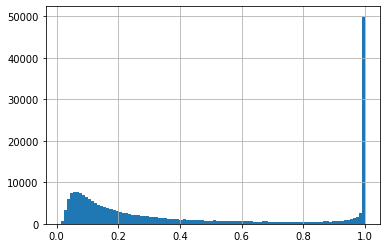

In [104]:
test_avg = test_df[['id', 'target']].copy()
test_avg['target'] = 0
# print(test_avg.describe())

total_weight = 0
for fold in Config.train_folds:
#     test_weight = {key+f'_Fold_{fold}':value for key,value in oof_weight.items()}
    test_weight = oof_weight #defaultdict(lambda:1)
    test_df2 = pd.read_csv(Config.model_output_folder + f"/test_Fold_{fold}.csv")
#     print(test_df2.describe())
    for col in test_df2.columns:
        col_weight = col.split('_Fold_')[0]
        if ('tta_' in col or 'preds' in col): 
#             print(col)
#             print(test_weight[col_weight])
            total_weight+=test_weight[col_weight]
            test_avg['target'] += test_df2[col]*test_weight[col_weight]
test_avg['target'] /= total_weight
print(test_avg.describe())
print(test_avg["target"].hist(bins=100))
print(test_avg)
print(total_weight)
test_avg.to_csv(Config.model_output_folder + "/test_avg.csv", index=False)

In [105]:
test_avg.describe()

,target
count,226000.000000
mean,0.443313
std,0.379427
min,0.013887
25%,0.107400
50%,0.266901
75%,0.952560
max,1.000000


In [106]:
test_avg[['id', 'target']].to_csv("./submission.csv", index=False)

test_avg[['id', 'target']].to_csv(Config.model_output_folder + "/submission.csv", index=False)

!mkdir -p ~/.kaggle/ && cp $Config.kaggle_json_path ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [107]:
# !kaggle competitions submit -c g2net-gravitational-wave-detection -f ./submission.csv -m $Config.model_version